# Main Objectives:
The scope of this project is to build several deep learning algorithms based on RNN techniques which can predict future values of an indicator using Time-Series Forecasting methods in order to achieve the highest possible accuracy. This can be broken down into the following milestones:

- Data Exploration and evaluation of Stationarity.
- Modeling and selection of best model.
- Prediction of future values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

df=pd.read_csv('./yahoo_stock.csv')

In [5]:
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import statistics

In [7]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [8]:
df.shape

(1825, 7)

Our dataset contains 6 columns of indicators and date columns which will be then set as index. Now let's see if the dates are unique or if there are duplicate values.

In [9]:
len(df['Date'].unique())

1825

As there are 1825 unique dates means that each one corresponds to unique records in the table, therefore we don't have duplicated or inconsistent values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [11]:
df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [12]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

As the date column is wrongly set as object type, let's change it to Datetime type:



In [13]:
df.Date=pd.to_datetime(df['Date'])

In [14]:
df.Date.min(),df.Date.max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

Let's compute the amount of days between the limits in the table, i.e. 2020-11-20/2015-11-23, take into account that the result will give us the days-1:

In [15]:
df.Date.max()-df.Date.min()

Timedelta('1824 days 00:00:00')

In [16]:
df.set_index('Date',inplace=True)

In [17]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Let's plot four of the indicators in the table and differentiate their corresponding curves by colours.



<AxesSubplot:xlabel='Date'>

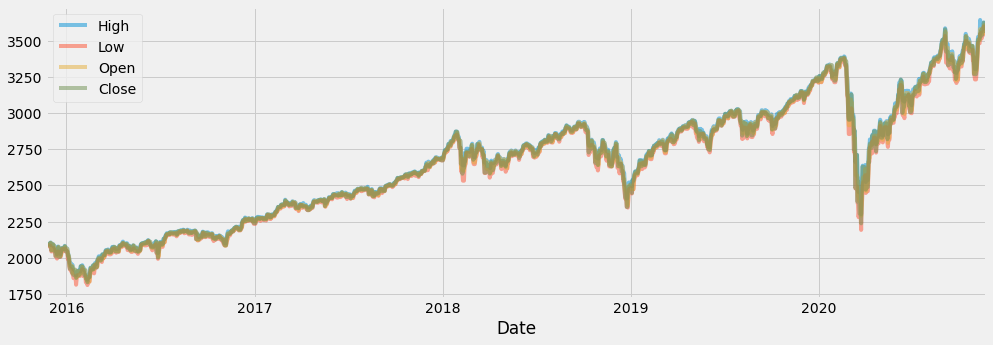

In [18]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)


The four had almost same behaviour troughout time and based on this assumption in this project we will only focus on one of them 'High' in order to build a model which could predict future values and then as possible suggestions extrapolate such model to other indicators.
Firstly, we will demonstrate if the time-series problem corresponds to a Non-Stationary type, which characterizes for having:

- Non-constant variance.
- Non-constant mean.
- Seasonality.
- High autocorrelation.

There are four well known ways to evaluate if the serie meets the criteria just mentioned, these corresponds to:

- Sequence visualization.
- Histogram, Autocorrelation and Partial Aurocorrelation plots.
- Statistical summary of chunks.
- Adfuller test.

# Evaluating Stationarity:


The following histogram plot should have a uniform distribution meaning **non-constant mean or 'trend'**:



<AxesSubplot:>

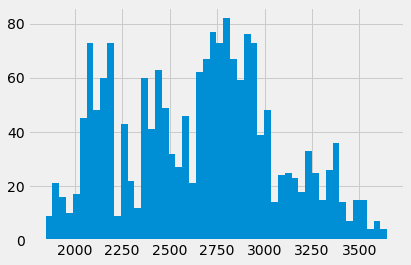

In [20]:
df.High.hist(bins=50)

We can't assume a uniform nor normal distribution in the plot above, because of that the statistical summary can helps us more, for this we will split the data into 10 chunks and compute mean and variance of each one.

In [21]:
np.round(df.shape[0]/10,0)

182.0

In [22]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['High'].iloc[(i*182):(i*182)+182].mean())
    std.append(stdev(df['High'].iloc[(i*182):(i*182)+182]))

In [23]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)


,mean,std
0,2019.354300,71.041024
1,2147.740282,36.287599
2,2322.969570,60.228422
3,2489.706581,55.878102
4,2711.253743,63.125935
5,2816.088946,68.351685
6,2754.165647,131.792411
7,2965.153137,74.059325
8,3045.669328,267.695412
9,3309.076588,165.733813


Above we see how both measures are clearly different in each chunk. However looking at the plot we could assume a constant variance as the ripple in the curve, but without a doubt trend is the most outstanding feature. Until now can assume it's a non-stationary serie, but to know more about it we will evaluate two other methods.

**Seasonal decomposition** is a function from statsmodels library which allows us to decompose the serie into trend, seasonal and residual, either additive or multiplicative:

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


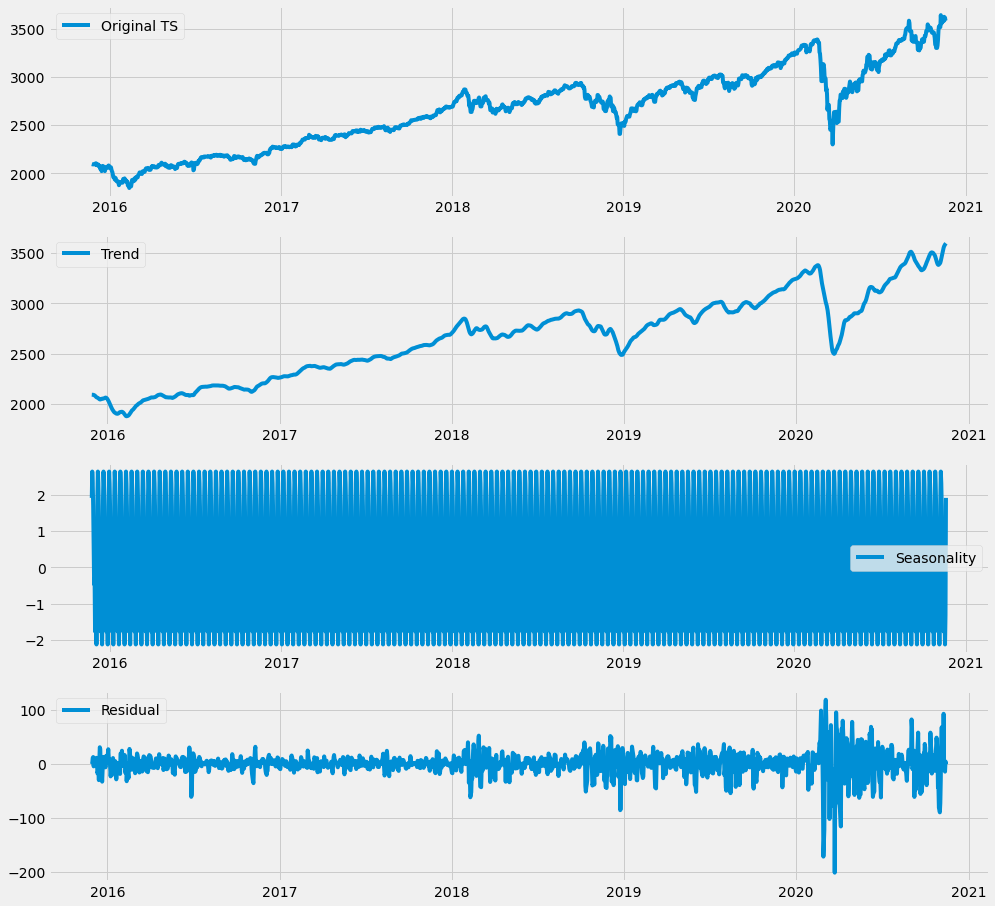

In [25]:
decompose_add=seasonal_decompose(df['High'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

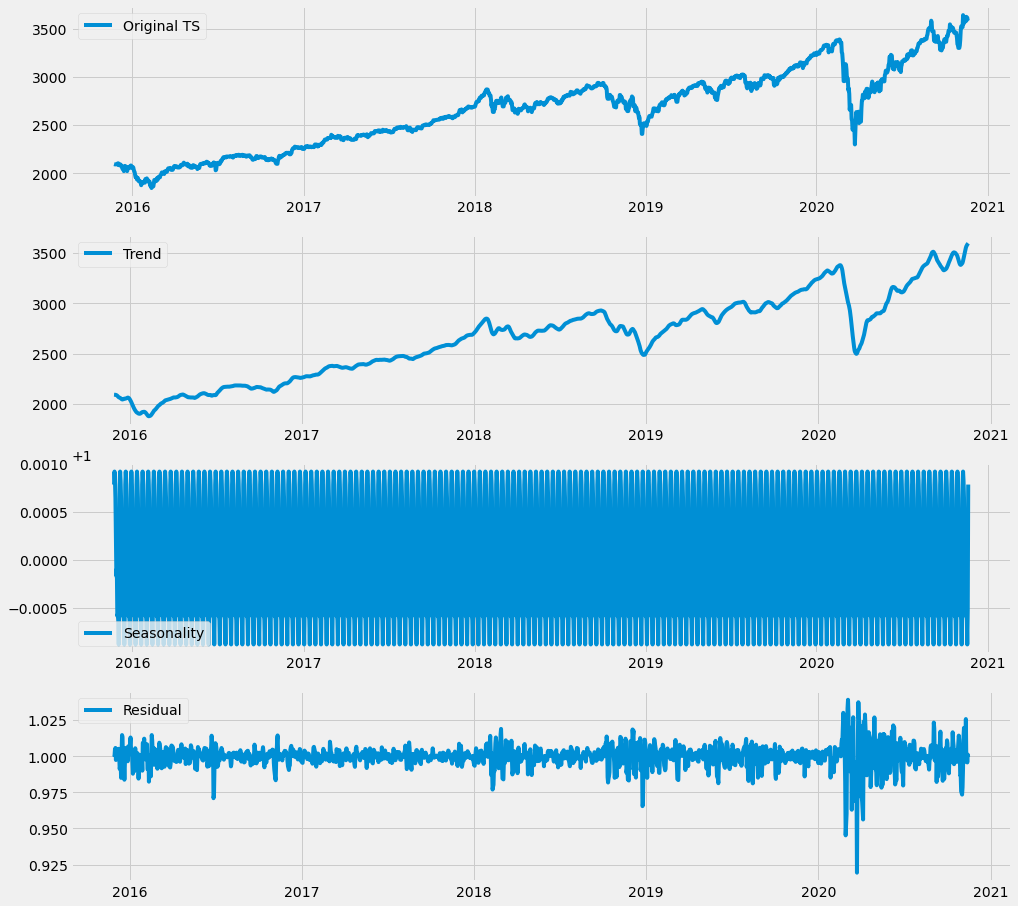

In [26]:
decompose_mul=seasonal_decompose(df['High'], model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

Looking carefully to the original curve we can say the additive decomposition makes more sense as the trend does not seem to be changing by the multiplication with seasonal component, rather every component seems to being added up to create the original curve. Independent of this there is a trend and seasonal component.
Below we can see the ACF and PACF plots:

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

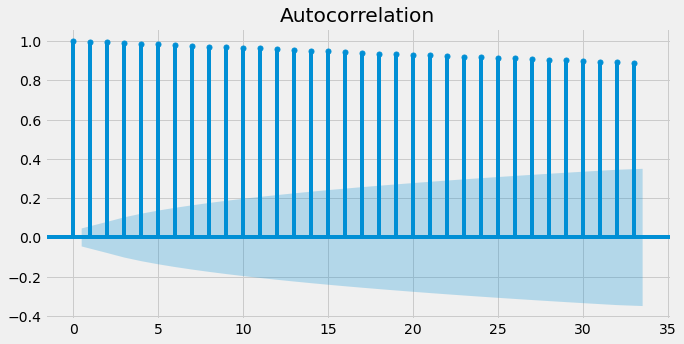

In [28]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['High'])
print()

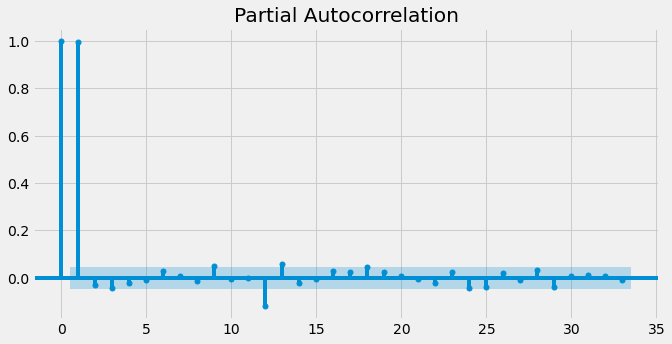

In [29]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
print()

Finally, we will make the Augmented Dickey-Fuller test, using 5% as significance level and declaring the following hypothesis:

- H0= Serie corresponds to non-stationary type.
- H1= Serie corresponds to stationary type.

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
result = adfuller(df['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.713598
p-value: 0.843196
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


As p-value is greater than 0.05 we fail to reject the null hypothesis, therefore there is not enough evidence to reject that we are working with a non-stationary series. Let's apply the log transformation to the serie and test again.

In [32]:
from numpy import log

result = adfuller(log(df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.920468
p-value: 0.781157
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Based on every method applied we can endorse the serie clearly corresponds to a non-stationary type, which means that we have to convert this to stationary by using filters and complex transformations. However, deep learning approaches can lead us to build models which takes into account all of these characteristics and predict future values modestly, but as disadvantage it would take significantly more time to train such models.

# Modeling:
In order to choose the best model 4 changes in hyperparameters and architecture will be applied and then evaluate each one by computing their corresponding error metrics. The purpose of this method is to find the appropriate characteristics of the model by looking at the effect of regularization, window length, number of epochs and type of cell. Each step will be denominated ‘comparison’ and are detailed as follows:

- 1st comparison, model with 7 different window length.
- 2nd comparison, model with more layers, neurons and epochs.
- 3rd comparison, model with regularization.
- 4th comparison, model using SimpleRNN vs LSTM.

Firstly, we will define a new dataset equal to the existing one, but omitting the last four records, later we will use the model to predict such values.



In [33]:
new_df=df['High'].iloc[:-4]

We define the length of the training set as 80% of the total records (specifically the first 80% of data, i.e.: from record 0 to record 1456):

In [34]:
train_len = math.ceil(len(new_df)*0.8)
train_len

1457

Let's use 10 as a random window to be used in the model to build:



In [36]:
window = 10

The following lines create the training sets, as we now the first row takes the first 10 time steps and then the second row takes time steps shifted in one and so on and so forth:

In [37]:
train_data = new_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [38]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

Reshaping the training set to (number of records-window, number of time steps, 1):



In [39]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1447, 10, 1)

In [40]:
X_train

array([[[2095.61010742],
        [2094.12011719],
        [2093.        ],
        ...,
        [2093.81005859],
        [2103.37011719],
        [2104.27001953]],

       [[2094.12011719],
        [2093.        ],
        [2093.        ],
        ...,
        [2103.37011719],
        [2104.27001953],
        [2085.        ]],

       [[2093.        ],
        [2093.        ],
        [2093.29003906],
        ...,
        [2104.27001953],
        [2085.        ],
        [2093.84008789]],

       ...,

       [[3078.34008789],
        [3097.77001953],
        [3093.09008789],
        ...,
        [3098.06005859],
        [3098.19995117],
        [3120.45996094]],

       [[3097.77001953],
        [3093.09008789],
        [3093.09008789],
        ...,
        [3098.19995117],
        [3120.45996094],
        [3120.45996094]],

       [[3093.09008789],
        [3093.09008789],
        [3093.09008789],
        ...,
        [3120.45996094],
        [3120.45996094],
        [3120.45996094]]

# Model
The following is the first model to be used, this is relatively simple with 
- one LSTM layer with relu activation function and one hidden fully connected layer, 
- the optimizer used is Adam, 
- number of epochs=10, 
- batch_size=10 and 
- loss function=Mean squared error:

In [41]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [42]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


Creating the validation set using same logic as training:



In [43]:
test_data = new_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [44]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [45]:
X_val.shape, Y_val.shape

((364, 10, 1), (364,))

Now that our validation set has the correct shape we can use it in the model to predict the next value.



In [46]:
prediction = model.predict(X_val)


In [47]:
len(prediction), len(Y_val)


(364, 364)

As our prediction and actual values have the same shape we can use these sets to compute the error metrics, in this case we will use RMSE.

In [48]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 33.88932152826689
Validation rmse: 92.06829544539704


Both errors are high, if we specifically see the validation one we could say it's too much and we aim to improve this as we build a robust model in the next steps.

Below is a table which merged the actual and predicted values, therefore we can see for each record how differ these two and have an idea of how sidetracked we currently are.

In [49]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3097.158936
2019-11-20,3118.969971,3100.322754
2019-11-21,3110.110107,3103.172852
2019-11-22,3112.870117,3106.739258
2019-11-23,3112.870117,3109.015381
...,...,...
2020-11-12,3569.020020,3478.763184
2020-11-13,3593.659912,3499.503418
2020-11-14,3593.659912,3538.150391


Below we can see a simple plot showing both curves, in which clearly there is a difference and a sort of shift to the right or delay in the prediction curve.

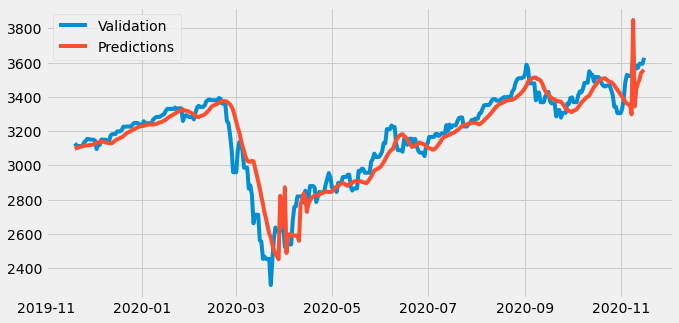

In [50]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Finally, the plot showing training, validation and prediction curves:



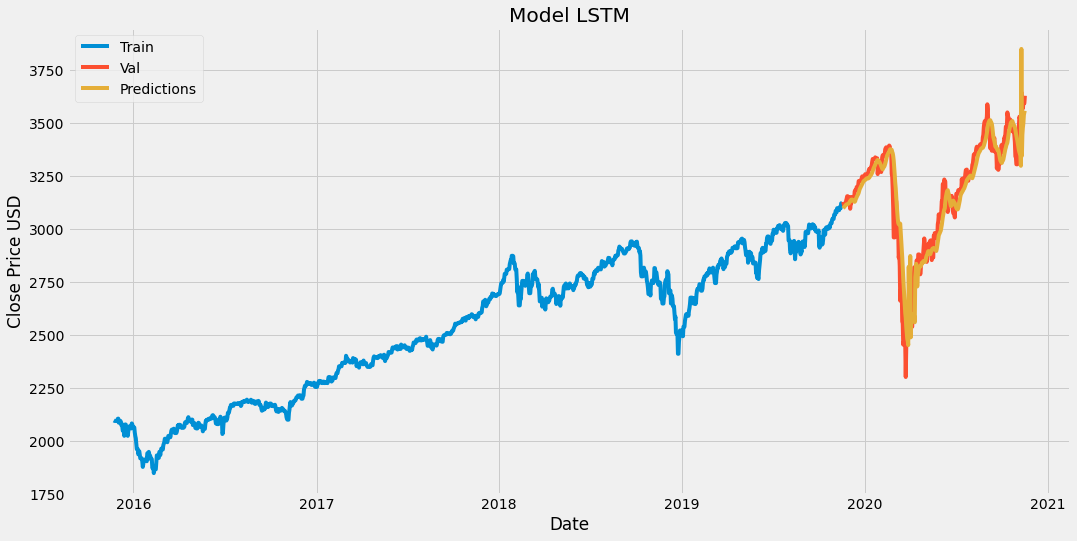

In [51]:
train = new_df[:train_len]
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

# 1st comparison:
In order to tackle down this 'shift' and thus reduce the error we have to find the suit window number, for this we will compute the RMSE for the following number of windows: 5,8,10,15,20,30,40. Then compare results and find the lowest.

In [52]:
train_error=[]
val_error=[]

window_number=[5,8,10,15,20,30,40]
for i in window_number:
    #_____________________________________________________________________
    train_data = new_df[0:train_len]

    X_train=[]
    Y_train=[]

    for i in range(window, len(train_data)):
        X_train.append(train_data[i-window:i])
        Y_train.append(train_data[i])

    X_train, Y_train= np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #______________________________________________________________________
    test_data = new_df[train_len-window:]

    X_val=[]
    Y_val=[] 

    for i in range(window, len(test_data)):
        X_val.append(test_data[i-window:i])
        Y_val.append(test_data[i])

    X_val, Y_val = np.array(X_val), np.array(Y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    #______________________________________________________________________
    model=Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)
    #______________________________________________________________________
    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
    val_error.append(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))


In [53]:
train_error

[47.62047778018526,
 37.07245978817491,
 30.055937003981192,
 33.04401029478792,
 30.696938997823924,
 27.233359001285518,
 38.483342941744375]

In [54]:
val_error

[123.90129727632551,
 100.24860884274503,
 84.24588223194071,
 93.21835898072483,
 84.57966537822873,
 74.51623248331889,
 92.43167403792427]

The following table shows the RMSE of train and validation sets for each of the 7 windows:



In [55]:
pd.concat([pd.DataFrame(train_error,columns=['train_error']),
           pd.DataFrame(val_error,columns=['val_error']),
           pd.DataFrame([5,8,10,15,20,30,40],columns=['window'])], axis=1).set_index('window')

,train_error,val_error
window,,
5,47.620478,123.901297
8,37.072460,100.248609
10,30.055937,84.245882
15,33.044010,93.218359
20,30.696939,84.579665
30,27.233359,74.516232
40,38.483343,92.431674


Note: Each time that I ran the prior code of 7 windows the outcome was different, but in general the behaviour was as in the table above, having window=10 the lowest RMSE for validation set. Thus this number was chosen as the best predictor. Even though before we have seen how for this value the shift was significant for all other windows this difference was much more, but there are still more hyperparameters to tune in order to improve the accuracy.

# 2nd comparison:
One efficient way to improve the accuracy is by simply increasing the complexity of the model and this can be achieved adding more layers and more LSTM cells. Therefore in this step we will build a multilayered model and compare its performance with the prior.
Firstly, let's create again the training and validation sets for 10 windows to be used.

In [56]:
window=10

train_data = new_df[0:train_len]
X_train=[]
Y_train=[]
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#____________________________________________________________________
test_data = new_df[train_len-window:]
X_val=[]
Y_val=[] 
for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])
    
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

The following is the architecture of the model to be used (2 LSTM layers and 2 hidden fully-connected layers), the optimizer is more specific and the number of epochs was increased to 100:



In [57]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1)
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 25)                2525      
                                                                 
 dense_18 (Dense)            (None, 1)                 26        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In the summary above we can see that the total parameters of this new model is three times or even more than the prior which is indicative of the complexity and the time it takes to train.

In [58]:
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 28.45232002761195
Validation rmse: 78.27862552077146


In [59]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

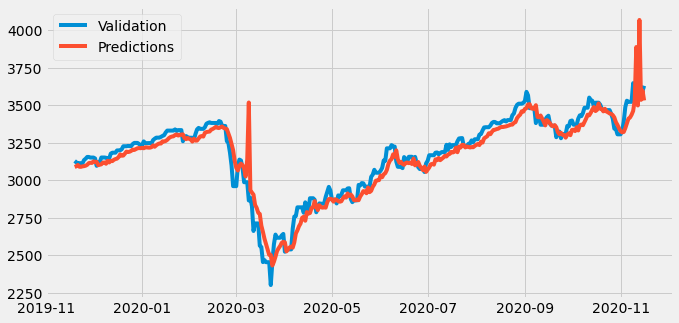

In [60]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Despite the fact that error metrics were lower than before in the plot above still can see a gap between the actual and predicted values. Again, I've found that each time I ran this model the results were different and the current output corresponds to the very best one, but in order to better vizualize this I will run 10 times the same model and compute the errors in each one.

In [61]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

Below we can see the RMSE for each time, note that these are considerably different, being still more impactful in the validation set.

In [62]:
r1, statistics.mean(r1), statistics.stdev(r1)

([29.78, 33.66, 34.33, 43.75, 25.98, 40.01, 30.49, 32.35, 32.9, 33.5],
 33.675,
 5.044053154182876)

In [63]:
r2, statistics.mean(r2), statistics.stdev(r2)


([81.25, 88.22, 75.75, 100.1, 71.22, 90.86, 62.26, 75.01, 78.41, 76.89],
 79.997,
 10.739538630686143)

We can see how validation errors are higher than training and also more spreaded because of such stardard deviation.



# 3rd comparison:
As the validation errors were still considerably higher than training we think one reason could be due to overfitting and for this problem we have to add regularization to the model chosen by using Dropout after Fully Connected layers and LSTM cells. In this step we will run a regularized model again 10 times in order to see the variation in the results:



In [64]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))


In [65]:
r1, statistics.mean(r1), statistics.stdev(r1)


([147.55, 73.34, 49.61, 33.9, 32.2, 37.16, 91.27, 57.19, 39.72, 64.07],
 62.601,
 35.39071769389382)

In [66]:
r2, statistics.mean(r2), statistics.stdev(r2)


([205.87, 125.04, 102.19, 93.22, 88.11, 93.84, 145.75, 89.75, 107.82, 118.49],
 117.008,
 36.16932027131404)

We can see above how these values either training or validation were higher than without dropout, which is definitely not good.

Note: Different levels of dropout were used above from 0.1 to 0.6 obtaining similar or higher errors. Now that we saw dropout did not reduce the errors we can not attribute the problem to overfitting and a different approach must be taken. For your consideration I have also changed the optimizer to Adadelta, Adamax, RMSProp and SGD but everyone had higher error or simply did not work, the activation function was changed to tanh and sigmoid obtaining similar errors.

# 4th comparison:
Until now every model built does not offer us a good accuracy, as we are dealing with the budget of a company this results can lead to a completely wrong decision, but as I said there is still a room of improvement and different approaches must be taken. We were forgeting the simplest type of RNN which is known for being more affected by vanishing gradient, however for our dataset it worked as follows (Again the model will be run 10 times):

In [67]:
from keras.layers import SimpleRNN


In [68]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

In [69]:
r1, statistics.mean(r1), statistics.stdev(r1)


([14.53, 24.13, 14.62, 14.47, 14.24, 13.98, 15.31, 31.21, 36.86, 38.44],
 21.779,
 10.089742260775985)

In [70]:
r2, statistics.mean(r2), statistics.stdev(r2)


([37.28, 44.92, 37.43, 37.27, 37.2, 37.15, 37.74, 50.62, 56.14, 57.53],
 43.328,
 8.410058528003502)

Wow!, even less than half the prior error metrics and what is more important is the fact that stardard deviation is much lower, which tells us that the model offer a more stable performance using RNNs rather than LSTMs.
Translating this to a more meaningful way the average error in the validation set reaches 41 USD with a std a bit higher than 4 USD.
Let's plot the actual and predicted values for the validation set and see how reduced was the 'shift':



In [71]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3168.943604
2019-11-20,3118.969971,3172.426514
2019-11-21,3110.110107,3162.357422
2019-11-22,3112.870117,3153.470215
2019-11-23,3112.870117,3156.449951
...,...,...
2020-11-12,3569.020020,3639.002686
2020-11-13,3593.659912,3611.346436
2020-11-14,3593.659912,3646.015625


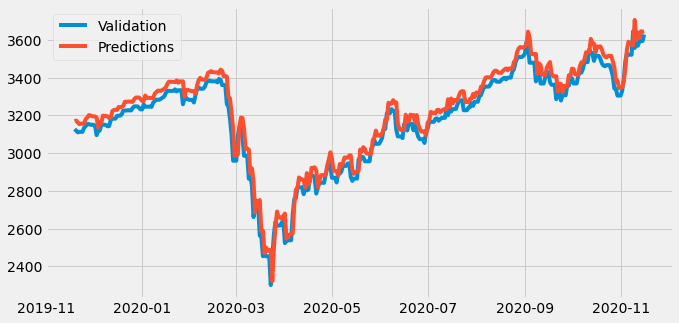

In [72]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Clearly, the gap was reduced significantly and the predicted curve even responded quickly to the 'high frequencies' or a.k.a. ripple in the actual curve. As this model corresponds to the best one we will continue working with this.

In order to get a bit better results from the previous model I will use a callback to find the learning rate wich offers the lowest MSE loss. I have already shorten the range to [1e-5 - 1e-3] and found that around 1e-4 and beta2 = 0.7 occurrs the lowest error, therefore these were chosen to rebuild the model:

In [73]:
import tensorflow 

r1=[]
r2=[]

model=Sequential()
model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
lr_schedule = tensorflow.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 85))
opt1=Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.7)
model.compile(loss='mean_squared_error', optimizer=opt1)
history=model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=2, callbacks=[lr_schedule])

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
r_train_new=np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2)
r_val_new=np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2)

Epoch 1/100
145/145 - 6s - loss: 6490241.5000 - lr: 1.0000e-05 - 6s/epoch - 40ms/step
Epoch 2/100
145/145 - 2s - loss: 2785225.7500 - lr: 1.0275e-05 - 2s/epoch - 16ms/step
Epoch 3/100
145/145 - 2s - loss: 357608.1875 - lr: 1.0557e-05 - 2s/epoch - 14ms/step
Epoch 4/100
145/145 - 2s - loss: 724.8529 - lr: 1.0847e-05 - 2s/epoch - 16ms/step
Epoch 5/100
145/145 - 2s - loss: 570.2731 - lr: 1.1144e-05 - 2s/epoch - 16ms/step
Epoch 6/100
145/145 - 2s - loss: 505.7934 - lr: 1.1450e-05 - 2s/epoch - 16ms/step
Epoch 7/100
145/145 - 2s - loss: 482.5422 - lr: 1.1765e-05 - 2s/epoch - 15ms/step
Epoch 8/100
145/145 - 3s - loss: 463.9734 - lr: 1.2088e-05 - 3s/epoch - 19ms/step
Epoch 9/100
145/145 - 3s - loss: 473.7466 - lr: 1.2420e-05 - 3s/epoch - 20ms/step
Epoch 10/100
145/145 - 3s - loss: 461.4419 - lr: 1.2761e-05 - 3s/epoch - 21ms/step
Epoch 11/100
145/145 - 4s - loss: 470.6754 - lr: 1.3111e-05 - 4s/epoch - 25ms/step
Epoch 12/100
145/145 - 4s - loss: 434.6267 - lr: 1.3471e-05 - 4s/epoch - 25ms/step
Ep

Epoch 100/100
145/145 - 3s - loss: 659.2530 - lr: 1.4612e-04 - 3s/epoch - 21ms/step


(1e-05, 0.0005, 0.0, 1000.0)

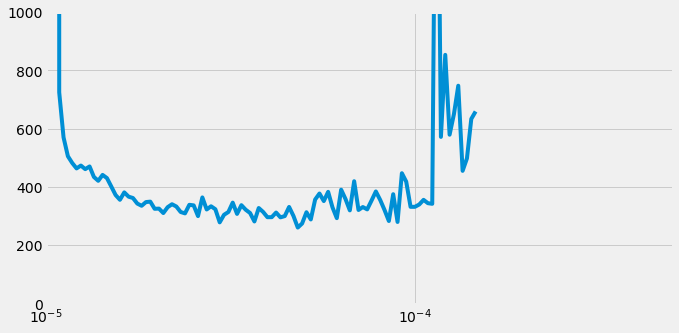

In [74]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 5e-4, 0, 1000])

Now that I have the best hyperparameters I will build again the model and evaluate its performance 15 times:



In [75]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=1e-4,beta_1=0.9,beta_2=0.7)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

In [76]:
r1, statistics.mean(r1), statistics.stdev(r1)


([21.78, 97.12, 18.07, 18.28, 14.33, 19.15, 15.15, 19.02, 14.93, 14.44],
 25.227,
 25.38175987681793)

In [77]:
r2, statistics.mean(r2), statistics.stdev(r2)


([43.71, 244.8, 40.65, 39.99, 38.02, 41.35, 40.04, 41.33, 39.83, 37.32],
 60.704,
 64.7090885253206)

The four metrics were reduced by chosing the right learning rate and betas, this made our model a bit more reliable as we will see next in the prediction:

In [78]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3130.640381
2019-11-20,3118.969971,3133.481201
2019-11-21,3110.110107,3122.248291
2019-11-22,3112.870117,3114.837402
2019-11-23,3112.870117,3116.860840
...,...,...
2020-11-12,3569.020020,3588.704102
2020-11-13,3593.659912,3567.115967
2020-11-14,3593.659912,3598.274170


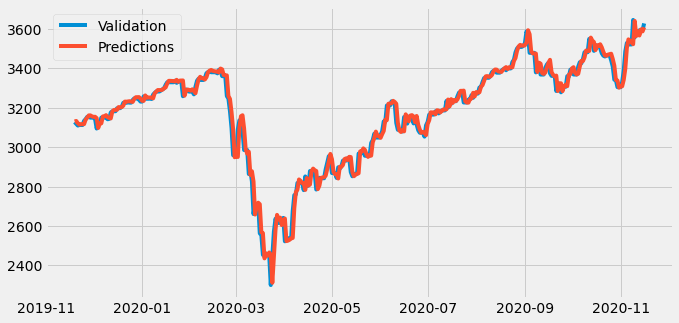

In [79]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

# Predicting 'future' values:
As we have values until 16-11-2020 we can predict the next one using the model built and compare the outcome with the actual value saved in the original dataframe 'df':

In [80]:
last_10_days=new_df[-10:].values
X_test=[]
X_test.append(last_10_days)
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred_price=model.predict(X_test)
print(pred_price)

[[3631.1792]]


Now, let's find the corresponding actual value in df:



In [81]:
df['High'].iloc[-4]


3623.110107421875

The difference is less than $18 USD and the model seems to be working very good.



In [82]:
df['High'].iloc[-4]-pred_price

array([[-8.069092]], dtype=float32)

Predicting 4 future values:



In [83]:
df.High.tail(14)

Date
2020-11-07    3521.580078
2020-11-08    3521.580078
2020-11-09    3645.989990
2020-11-10    3557.219971
2020-11-11    3581.159912
2020-11-12    3569.020020
2020-11-13    3593.659912
2020-11-14    3593.659912
2020-11-15    3593.659912
2020-11-16    3628.510010
2020-11-17    3623.110107
2020-11-18    3619.090088
2020-11-19    3585.219971
2020-11-20    3581.229980
Name: High, dtype: float64

Above, the last 4 values correspond to the actual values we want to predict, and the time steps used does not comprehend these rather will be used the predicted ones as we run the model.
As we predicted one value (pred_price) the time steps used to predict a new one will take the last 9 of new_df and pred_price, as follows:

In [84]:
last_9_days=new_df[-9:].values
X_test=[]
X_test=np.append(last_9_days,pred_price)
X_test=np.array(X_test)
X_test
X_test=np.reshape(X_test,(1,X_test.shape[0],1))
pred_price2=model.predict(X_test)
print(pred_price2)

[[3640.5947]]


Nice!, let's see what was the actual value:



In [85]:
df['High'].iloc[-3]


3619.090087890625

This time the difference was:



In [86]:
df['High'].iloc[-3]-pred_price2


array([[-21.504639]], dtype=float32)

To compute a new prediction let's use the same logic as before:



In [87]:
last_8_days=new_df[-8:].values
X_test=[]
X_test=np.append(last_8_days,pred_price)
X_test=np.append(X_test,pred_price2)
X_test=np.array(X_test)
X_test
X_test=np.reshape(X_test,(1,X_test.shape[0],1))
pred_price3=model.predict(X_test)
print(pred_price3)

[[3647.8794]]


Actual value:



In [88]:
df['High'].iloc[-2]


3585.219970703125

Difference:



In [89]:
df['High'].iloc[-2]-pred_price3


array([[-62.659424]], dtype=float32)

In [90]:
last_7_days=new_df[-7:].values
X_test=[]
X_test=np.append(last_7_days, pred_price)
X_test=np.append(X_test, pred_price2)
X_test=np.append(X_test, pred_price3)
X_test=np.array(X_test)
X_test
X_test=np.reshape(X_test,(1,X_test.shape[0],1))
pred_price4=model.predict(X_test)
print(pred_price4)


[[3655.6692]]


In [91]:
df['High'].iloc[-1]


3581.22998046875

In [92]:
df['High'].iloc[-1]-pred_price4


array([[-74.43921]], dtype=float32)

Now, let's see the four actual and predicted future values:



In [93]:
df.High.iloc[-4], df.High.iloc[-3], df.High.iloc[-2], df.High.iloc[-1]


(3623.110107421875, 3619.090087890625, 3585.219970703125, 3581.22998046875)

In [94]:
pred_price, pred_price2, pred_price3, pred_price4


(array([[3631.1792]], dtype=float32),
 array([[3640.5947]], dtype=float32),
 array([[3647.8794]], dtype=float32),
 array([[3655.6692]], dtype=float32))

The following code will help us visualize these values in a table and plot:



In [95]:
actual_prices=np.array([df.High.iloc[-4], df.High.iloc[-3], df.High.iloc[-2], df.High.iloc[-1]])
pred_prices=np.array([float(pred_price),float(pred_price2),float(pred_price3),float(pred_price4)])


In [96]:
actual_prices, pred_prices

(array([3623.11010742, 3619.09008789, 3585.2199707 , 3581.22998047]),
 array([3631.17919922, 3640.59472656, 3647.87939453, 3655.66918945]))

In [97]:
data={'Actual values':[df.High.iloc[-4],df.High.iloc[-3],df.High.iloc[-2],df.High.iloc[-1]],
      'Predicted values':[float(pred_price),float(pred_price2),float(pred_price3),float(pred_price4)]}

pd.DataFrame(data, index=['2020-11-17','2020-11-18','2020-11-19','2020-11-20'])

,Actual values,Predicted values
2020-11-17,3623.110107,3631.179199
2020-11-18,3619.090088,3640.594727
2020-11-19,3585.219971,3647.879395
2020-11-20,3581.229980,3655.669189


[(3540.0, 3700.0)]

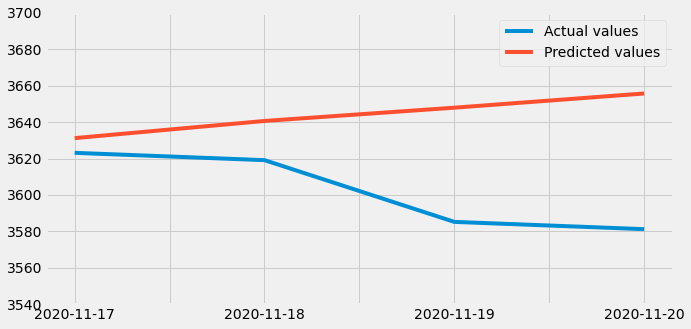

In [98]:
fut=pd.DataFrame(data, index=['2020-11-17','2020-11-18','2020-11-19','2020-11-20']).plot()
fut.set(ylim=(3540,3700))

The plot above shows how sidetracked our prediction is from the actual values, this will impact our conclussion about complexity of model vs reliable forecasting, now will be computed the correspoding RMSE to see this difference quantified:



In [99]:
np.round(np.sqrt(mean_squared_error(actual_prices, pred_prices)),2)


49.99

# Key findings:
Definitely Time-series forecasting is incredibly complex, despite the fact that using Deep Learning approaches somehow increases the accuracy it also makes more difficult the interpretability and particularly for this dataset it did not work stably, I mean every time I run this code the results were much significantly different, even more than what I am used to see. Nevertheless is the long time it took to train the models and in order to build a more complex architecture as a hypothesis to increase accuracy it must be taken into account.

One outstanding detail about the performance of the best model chosen is the low variance in the error metrics, which makes this the most stable system and gave us the key factor in this project. Also the gap seems to have been dropped to an insignificant level, but do not misinterpret this as looking at the plot both curves looks almost the same, however they have a big difference quantified as RMSE reaching 40 USD which makes a big difference in the budget.

The prediction of 'future' values is a task whose risk increases exponentially as we want to predict more time steps becoming non-reliable, this is because we are comprehending predicted values which obviously has certain error and trying to predict new ones adds even more error in this case 'additive'. Once we understand this effect in our context would not be recommended to predict more than two time steps so as to not lead to wrong decisions.

In the last plot of actual and predicted future values shows that our prediction had a linear behaviour keeping a constant slope through time which indicates the model needs some regularization or dropout which could add non-linearity. This idea was implemented to the current best model, but the result were horribly bad, even worse than LSTMs using Dropout, making us again take different approaches if we wish to improve the model.

Finally, the current model is only recommended for learning purposes as particularly I would not use it to predict economical indicators of any company, having said this the model and work achieved can be extrapolated to the other 3 indicators in the original dataset.

# Suggestions:
Having the scope of improve the prediction I would take into account some approaches of Linear Regression as these comprehend several features ideally highly correlated to the label, so a good idea and future work would be to implement or combine Lasso/Ridge Regression with Time-Series Forecasting. I am relatively novice in ML, really don't know if this already exist, but in the following weeks I will be researching more to do exactly this.

reference: https://www.kaggle.com/georgesaavedra/time-series-forecasting/data